In [1]:
import pandahouse as ph
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
sns.set(
    font_scale=2,
    style='whitegrid',
    rc={'figure.figsize': (20, 7)}
)

In [3]:
connection = dict(database='default',
                  host='https://clickhouse.lab.karpov.courses',
                  user='student',
                  password='dpo_python_2020')

In [4]:
# выгрузим из базы данных датасет, содержащий информацию об объявлениях на Airbnb в Лондоне
query = """
SELECT
    id,
    listing_url,
    room_type,
    latitude,
    longitude,
    minimum_nights,
    accommodates,
    bathrooms,
    bedrooms,
    beds,
    amenities,
    host_is_superhost,
    number_of_reviews,
    toFloat32OrNull(review_scores_rating) AS scores_rating,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
FROM ldn_listings
WHERE review_scores_rating <> '' and price > 0
ORDER BY id
"""
df = ph.read_clickhouse(query, connection=connection)
df.head()

,id,listing_url,room_type,latitude,longitude,minimum_nights,accommodates,bathrooms,bedrooms,beds,amenities,host_is_superhost,number_of_reviews,scores_rating,price
0,13913,https://www.airbnb.com/rooms/13913,Private room,51.568020000000004,-0.11120999999999999,1,2,1.0,1.0,0.0,"{TV,""Cable TV"",Wifi,Kitchen,""Paid parking off ...",f,21,97.0,65.0
1,15400,https://www.airbnb.com/rooms/15400,Entire home/apt,51.48796,-0.16898,10,2,1.0,1.0,1.0,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",f,89,96.0,100.0
2,17402,https://www.airbnb.com/rooms/17402,Entire home/apt,51.52195,-0.14094,3,6,2.0,3.0,3.0,"{TV,Wifi,Kitchen,""Paid parking off premises"",E...",f,42,94.0,300.0
3,25023,https://www.airbnb.com/rooms/25023,Entire home/apt,51.446870000000004,-0.21874000000000002,21,4,1.0,2.0,2.0,"{TV,Wifi,Kitchen,""Free parking on premises"",El...",t,35,93.0,65.0
4,25123,https://www.airbnb.com/rooms/25123,Private room,51.57224,-0.20906,10,2,1.5,1.0,0.0,"{Wifi,Kitchen,""Free street parking"",""Buzzer/wi...",t,129,96.0,29.0


- id - id объявления
- listing_url - ссылка на объявление
- room_type - тип жилья
    - Private room - отдельная комната
    - Hotel room - комната в отеле
    - Entire home/apt - жильё целиком
    - Shared room - место в комнате
- latitude - широта жилья
- longitude - долгота жилья
- minimum_nights - минимальное количество дней, на которое можно забронировать жильё
- accommodates - максимальное количество гостей
- bathrooms - количество ванных комнат
- bedrooms - количество спален
- beds - количество кроватей
- amenities - удобства
- host_is_superhost:
    - t - суперхозяин
    - f - нет
- number_of_reviews - количество отзывов
- scores_rating - рейтинг
- price – цена за ночь

In [5]:
df.shape

(62112, 15)

Хотим проверить, что price отличается для различных типов жилья. Хотим попробовать применить t-критерий, но предварительно нужно:
    1. Проверить нормальность данных;
    2. Проверить гомогенность дисперсий

In [6]:
x1 = df[df.room_type == 'Private room']
x2 = df[df.room_type == 'Hotel room']
x3 = df[df.room_type == 'Entire home/apt']
x4 = df[df.room_type == 'Shared room']
x1.name, x2.name, x3.name, x4.name = 'Private room', 'Hotel room', 'Entire home/apt', 'Shared room'

Text(0.5, 1.0, 'Гистограмма цен Private room')

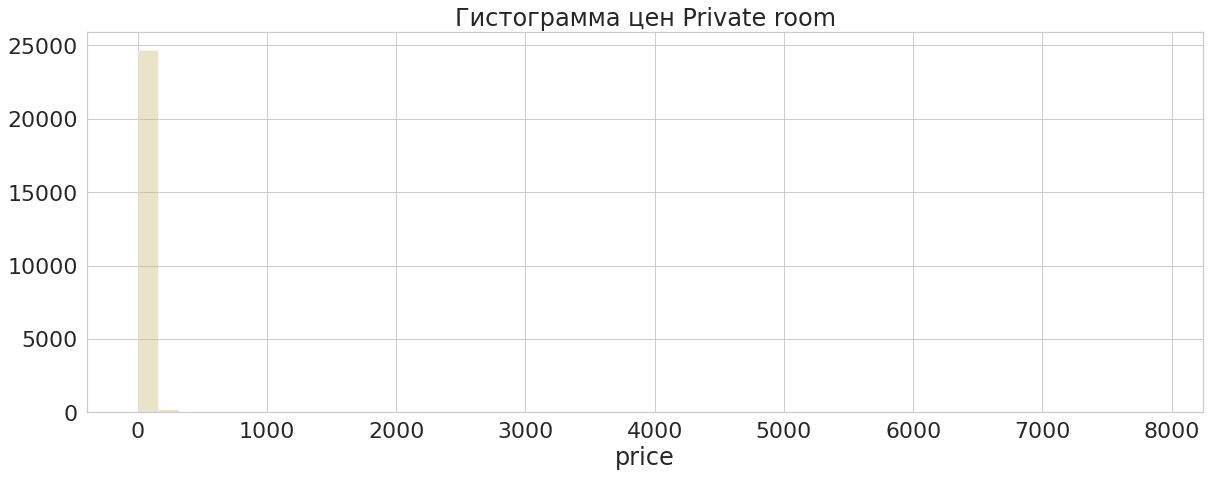

In [7]:
sns.distplot(x1.price, color="y", kde=False)
plt.title(f'Гистограмма цен {x1.name}')

Text(0.5, 1.0, 'Гистограмма цен Hotel room')

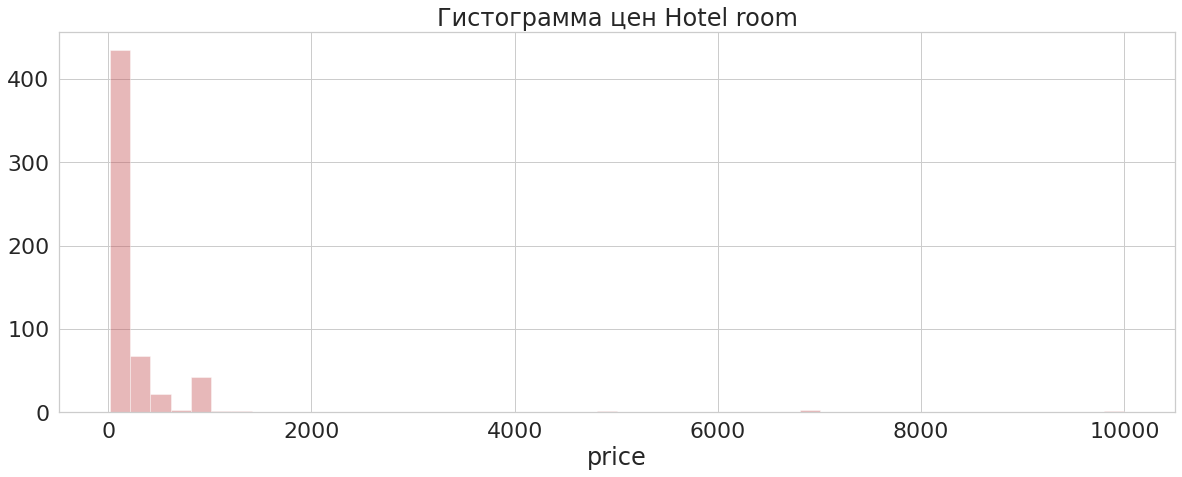

In [8]:
sns.distplot(x2.price, color="r", kde=False)
plt.title(f'Гистограмма цен {x2.name}')

Text(0.5, 1.0, 'Гистограмма цен Entire home/apt')

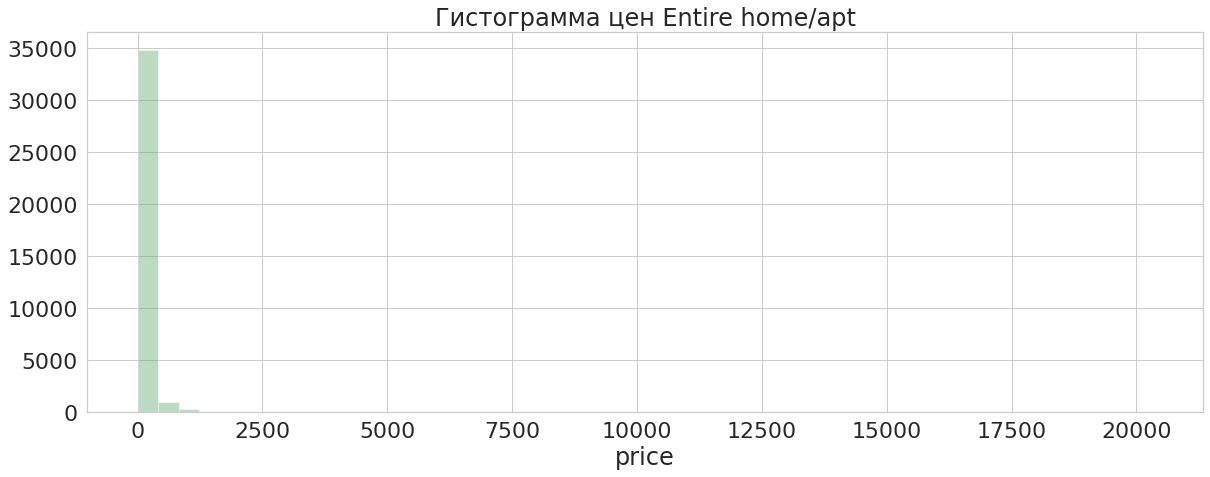

In [9]:
sns.distplot(x3.price, color="g", kde=False)
plt.title(f'Гистограмма цен {x3.name}')

Text(0.5, 1.0, 'Гистограмма цен Shared room')

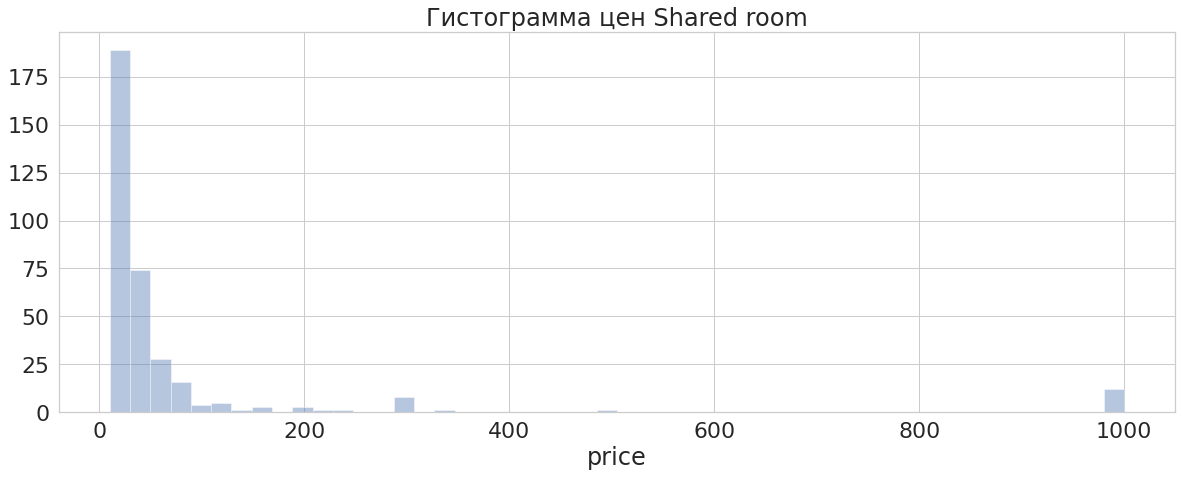

In [10]:
sns.distplot(x4.price, kde=False)
plt.title(f'Гистограмма цен {x4.name}')

Как мы видим, распределения цен далеки от нормального. Попробуем прологарифмировать значения цен и посмотреть на гистограммы.

Text(0.5, 1.0, 'Гистограмма цен Private room')

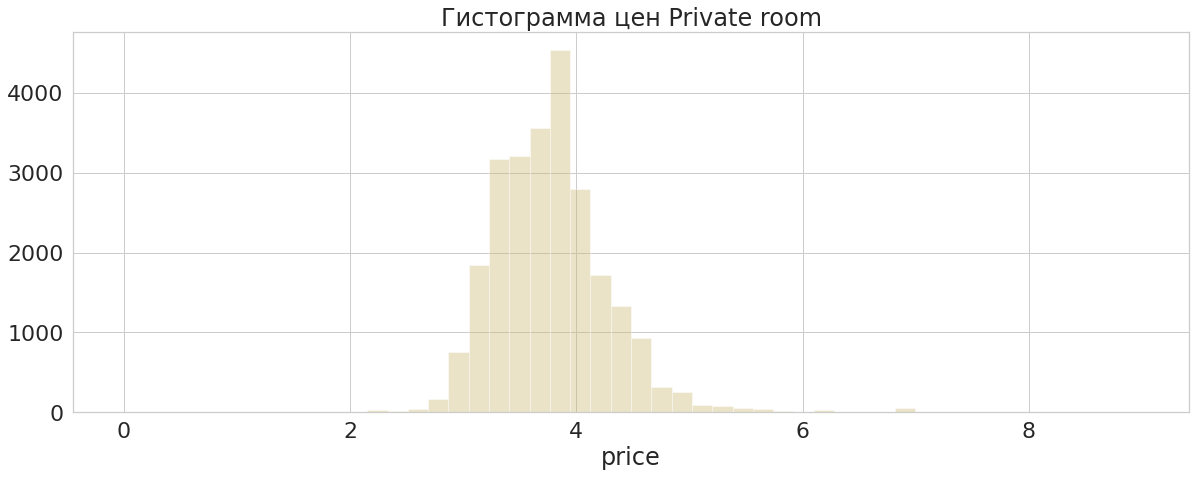

In [11]:
sns.distplot(np.log(x1.price), color="y", kde=False)
plt.title(f'Гистограмма цен {x1.name}')

Text(0.5, 1.0, 'Гистограмма цен Hotel room')

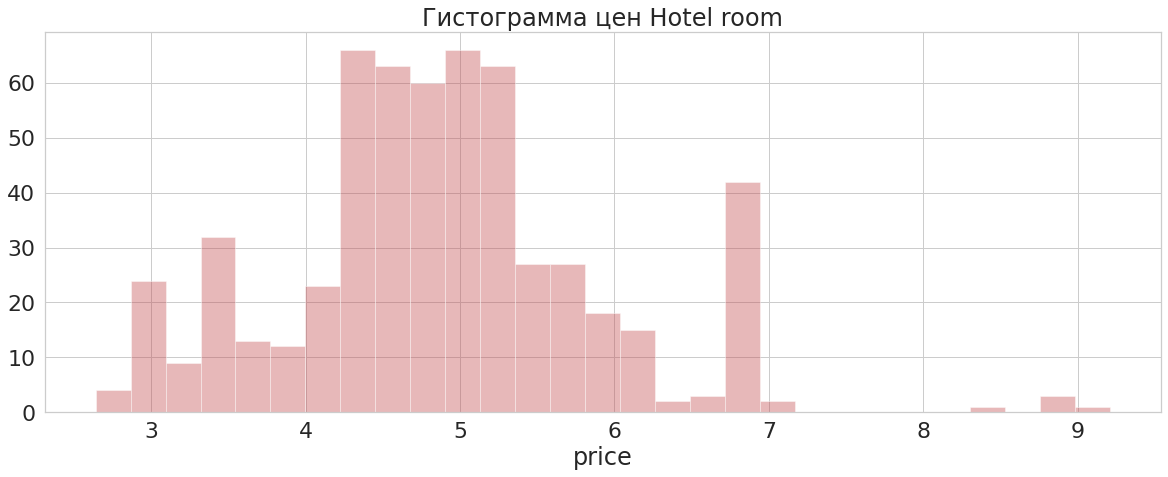

In [12]:
sns.distplot(np.log(x2.price), color="r", kde=False)
plt.title(f'Гистограмма цен {x2.name}')

Text(0.5, 1.0, 'Гистограмма цен Entire home/apt')

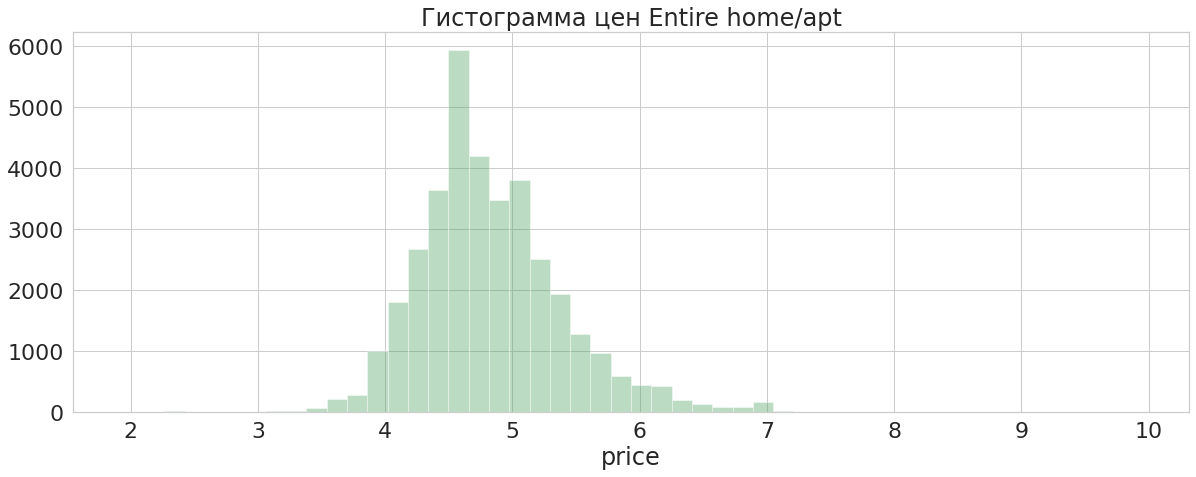

In [13]:
sns.distplot(np.log(x3.price), color="g", kde=False)
plt.title(f'Гистограмма цен {x3.name}')

Text(0.5, 1.0, 'Гистограмма цен Shared room')

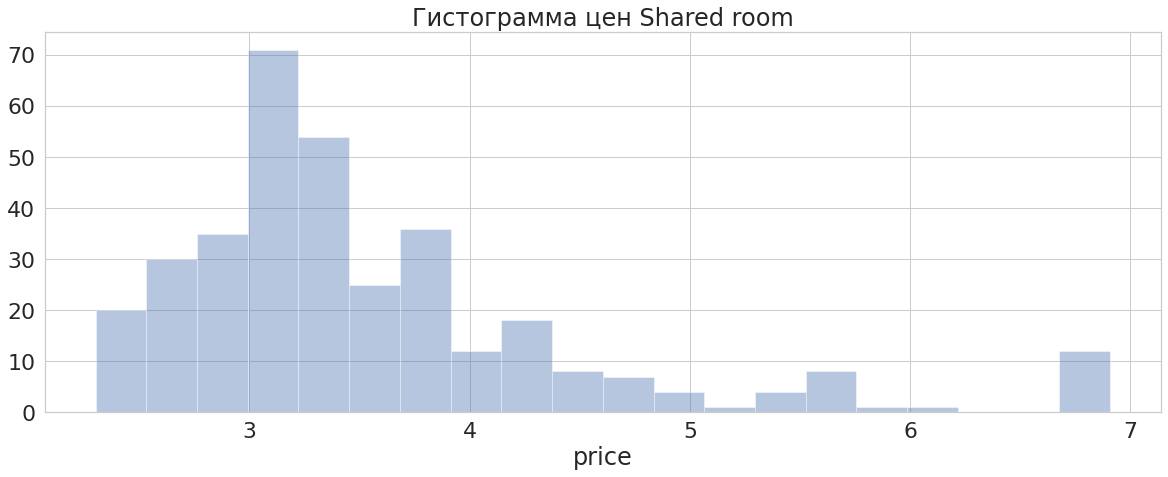

In [14]:
sns.distplot(np.log(x4.price), kde=False)
plt.title(f'Гистограмма цен {x4.name}')

При таком подходе в распределениях всё же присутствуют выбросы, которые не дают применить критерий Стьюдента. Можно было бы попробовать от них избавиться, но по гистограммам заметно, что от этого убавится значительная часть наблюдений. В таком случае попробуем применить непараметрический критерий Манна-Уитни.

In [15]:
from scipy.stats import mannwhitneyu

In [18]:
# 1
mannwhitneyu(x1.price, x2.price)

MannwhitneyuResult(statistic=2289960.0, pvalue=8.71173529764106e-174)

In [19]:
# 2
mannwhitneyu(x1.price, x3.price)

MannwhitneyuResult(statistic=61234607.0, pvalue=0.0)

In [20]:
# 3
mannwhitneyu(x1.price, x4.price)

MannwhitneyuResult(statistic=2759917.0, pvalue=5.715489042482567e-32)

In [21]:
# 4
mannwhitneyu(x2.price, x3.price)

MannwhitneyuResult(statistic=10030500.0, pvalue=0.06799847930016845)

In [22]:
# 5
mannwhitneyu(x2.price, x4.price)

MannwhitneyuResult(statistic=30306.5, pvalue=8.193126021095431e-71)

In [23]:
# 6
mannwhitneyu(x3.price, x4.price)

MannwhitneyuResult(statistic=1340996.0, pvalue=5.824889988410868e-141)

Заметим, что во всех случаях, кроме 4-го H0 гипотеза о равенстве распределений была отклонена (при уровне значимости 0,05).

In [34]:
from scipy.stats import shapiro, boxcox

Попробуем рассмотреть 4-й случай, применив t-тест, предварительно немного преобразовав данные. Воспользуемся методом Бокса-Кокса и найдём в цикле оптимальный параметр лямбда, проверяя распределение на нормальность с помошью теста Шапиро-Уилка.

In [35]:
def search_lambda(values):
    '''функции подается на вход вектор значений, далее из них берется выборка,
    применяется преобразование Бокса-Кокса и в цикле находится оптимальный параметр лямбда,
    при котором p-value на тесте Шапиро-Уилка максимальный'''
    from scipy.stats import shapiro, boxcox
    if values.shape[0] > 1000:
        values = values.sample(1000, random_state=17)
    l = -1
    min_l = 0
    p_value = 0
    while l <= 1:
        if shapiro(boxcox(values, l))[1] > p_value:
            min_l = l
            p_value = shapiro(boxcox(values, l))[1]
        l += 0.025
        
    print(f'lambda={round(min_l, 2)}, p-value={p_value}')

In [36]:
search_lambda(x2.price)

lambda=-0.15, p-value=1.0962739338538086e-07


In [37]:
search_lambda(x3.price)

lambda=-0.25, p-value=6.10219475860943e-14


Далее преобразуем данные с помощью метода Бокса-Кокса с усредненным значнием lambda. Посмотрим на распределения визуально.

In [38]:
l = - (0.25 + 0.15) / 2

In [39]:
x2['boxcox_price'] = boxcox(x2.price, l)
x3['boxcox_price'] = boxcox(x3.price, l)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Гистограмма цен Hotel room')

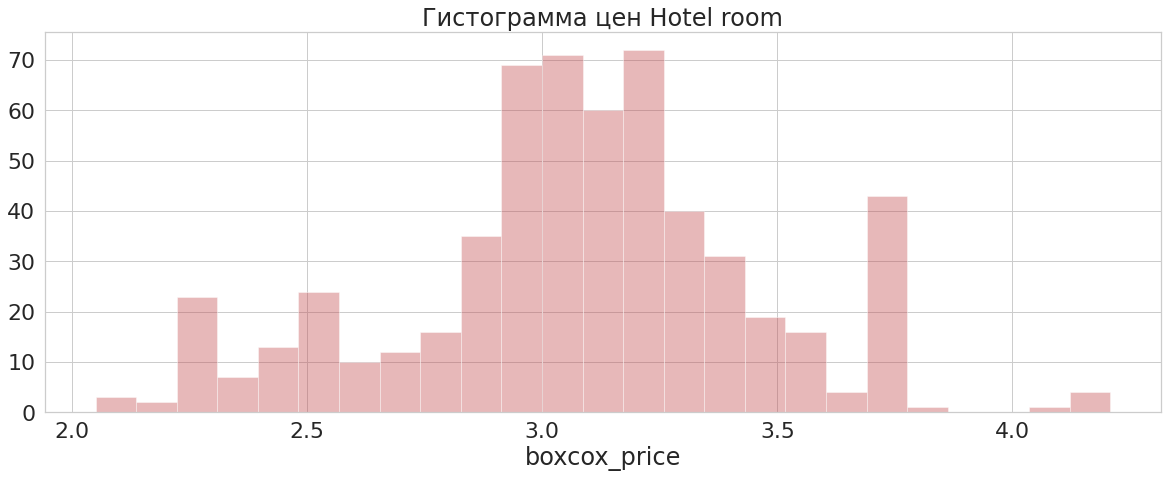

In [40]:
sns.distplot(x2.boxcox_price, color="r", kde=False)
plt.title(f'Гистограмма цен {x2.name}')

Text(0.5, 1.0, 'Гистограмма цен Entire home/apt')

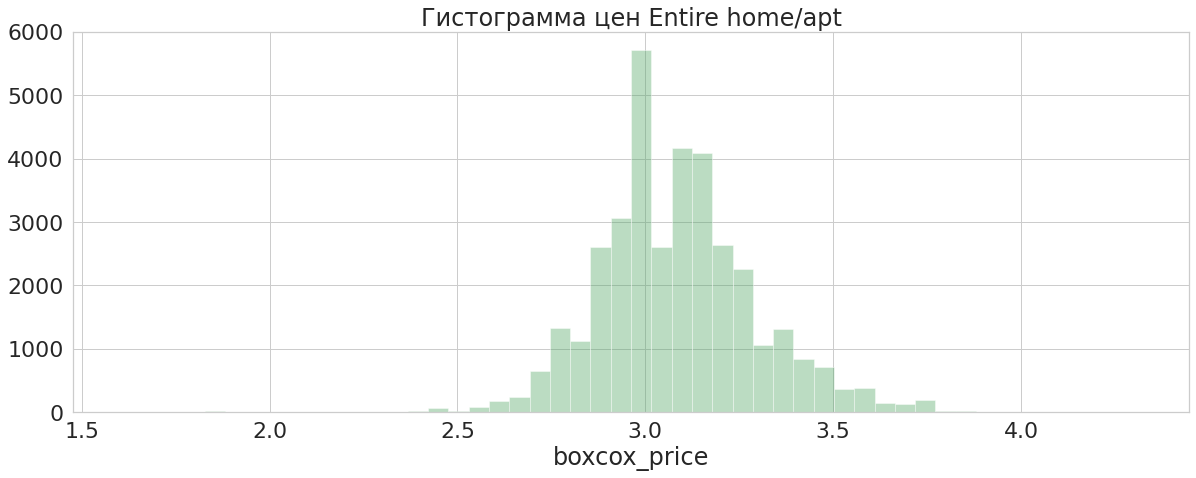

In [41]:
sns.distplot(x3.boxcox_price, color="g", kde=False)
plt.title(f'Гистограмма цен {x3.name}')

Отфильтруем выбросы > 4 и < 2 и посмотрим как изменится результат исследования распределений на нормальность.

In [42]:
shapiro(x2.boxcox_price)

(0.976198136806488, 4.616304849491826e-08)

In [43]:
shapiro(x2.query('boxcox_price > 2 & boxcox_price < 4').boxcox_price)

(0.9684643745422363, 9.838563297392966e-10)

In [44]:
shapiro(x3.boxcox_price.sample(1000, random_state=17))

(0.9665541052818298, 2.166850378325976e-14)

In [45]:
shapiro(x3.query('boxcox_price > 2 & boxcox_price < 4').boxcox_price.sample(1000, random_state=17))

(0.9811097979545593, 4.235876649438808e-10)

Для x3 результат улучшился, а для x2 - ухудшился, оставим фильтрацию только для x3. В итоге имеем:

Text(0.5, 1.0, 'Гистограмма цен Hotel room')

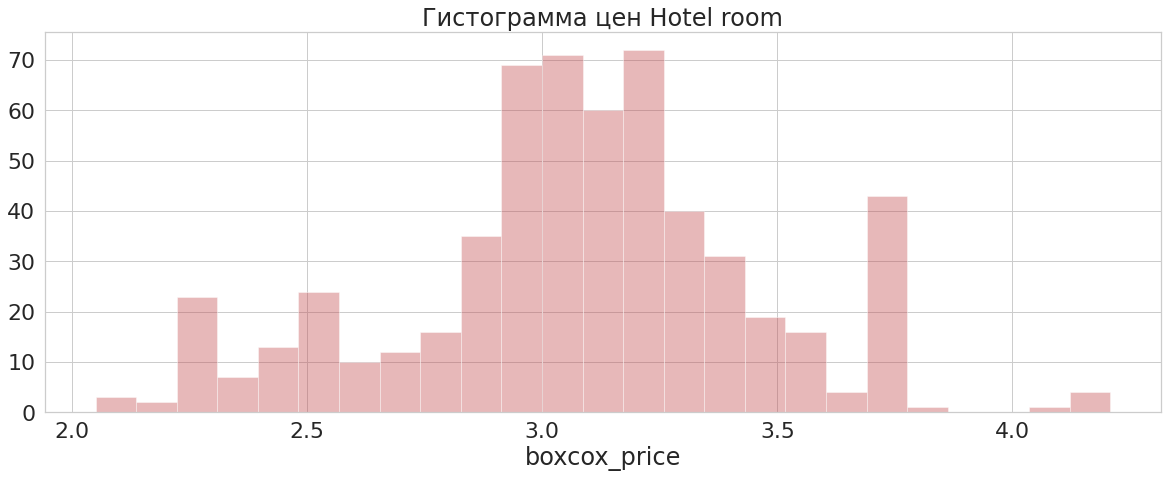

In [46]:
sns.distplot(x2.boxcox_price, color="r", kde=False)
plt.title(f'Гистограмма цен {x2.name}')

Text(0.5, 1.0, 'Гистограмма цен Entire home/apt')

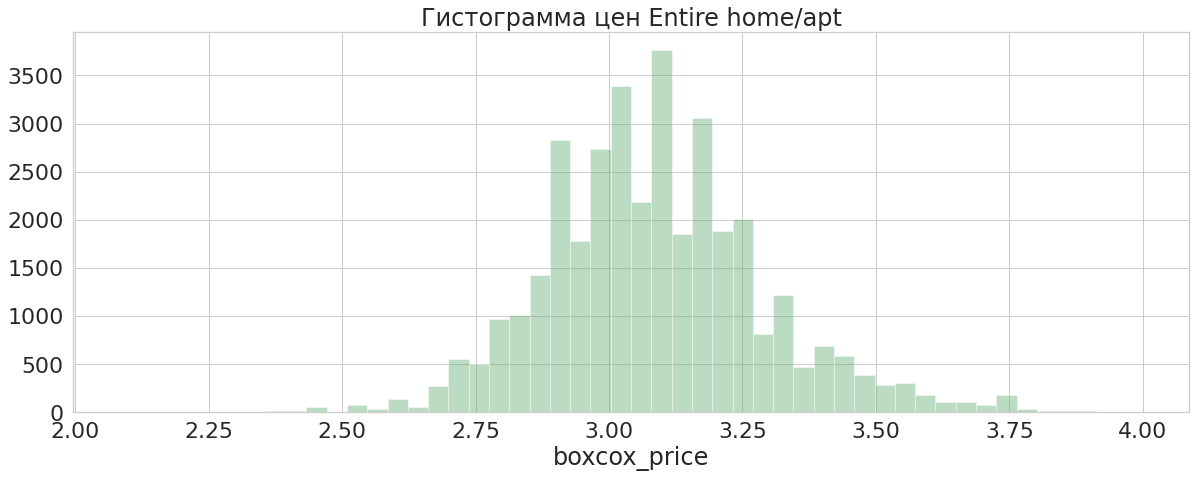

In [47]:
sns.distplot(x3.query('boxcox_price > 2 & boxcox_price < 4').boxcox_price, color="g", kde=False)
plt.title(f'Гистограмма цен {x3.name}')

Проверим дисперсии внутри наших групп на гомогенность, используя тест Левена

In [48]:
from scipy.stats import levene
levene(x2.boxcox_price, x3.query('boxcox_price > 2 & boxcox_price < 4').boxcox_price)

LeveneResult(statistic=531.2540705690834, pvalue=1.0214278383209053e-116)

Гипотезу о гомогенности дисперсий отвергаем, т.к. p-value много меньше 0.05. Раз в двух выборках находятся разные наблюдаемые объекты (выборки несвязные), гипотезу о равенстве средних значений x2 и x3 будем проверять с помошью ttest_ind с опцией equal_var=False.

In [49]:
x2.boxcox_price.mean()

3.0799365

In [50]:
x3.query('boxcox_price > 2 & boxcox_price < 4').boxcox_price.mean()

3.0842404

In [51]:
from scipy.stats import ttest_ind
ttest_ind(x2.boxcox_price,
         x3.query('boxcox_price > 2 & boxcox_price < 4').boxcox_price,
         equal_var=False)

Ttest_indResult(statistic=-0.2685741898691364, pvalue=0.7883528207452732)

p-value равен 0.79 (больше 0.05), следовательно гипотезу о равенстве средних значений x2 и x3 мы не отвергаем.

Вывод: распределения цен для всех типов жилья, кроме Hotel room и Entire home/apt по тесту Манна-Уитни статистически значимо различаются между собой. С помощью t-теста была проверена гипотеза о равенстве средних значений цен Hotel room и Entire home/apt, отвергнуть её не удалось.